In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import helpers
import networkx as nx
import numpy as np
import os

from matplotlib import pyplot as plt
from sklearn.metrics import log_loss
from networkx.algorithms.distance_measures import diameter
from decentralized_SGD_logistic import DecentralizedSGDLogistic
from sklearn.linear_model import SGDClassifier

## Load Higgs Boson dataset

In [3]:
y, A = helpers.load_data()

## Compute the baseline with SGD classifier 

In [4]:
# Fit a SGD
clf = SGDClassifier(loss='log', penalty='l2',alpha =1/A.shape[0], tol=1e-4, n_jobs=1, random_state=2)
clf.fit(A, y)

accuracy = clf.score(A, y)
optimum_x = clf.predict_proba(A)[:, 1]

# Optimal loss, useful for plots
optimum_loss = (-(y.T.dot(np.log(optimum_x)) + (1 - y).T.dot(np.log(1 - optimum_x))) / A.shape[0])

print('Accuracy:', accuracy)
print('Final loss:', optimum_loss)

Accuracy: 0.7444
Final loss: 0.5063267378689544


## Computing with Decentralized SGD

### Real Social Network Graph

In [47]:
G = nx.read_gml('power.gml', label='id')
G = G.to_undirected()
n_machines = G.number_of_nodes()
real_network_topology = nx.adjacency_matrix(G).toarray() + np.eye(n_machines)

print('Number of nodes: ' + str(n_machines))
print('Number of edges: ' + str(G.number_of_edges()))

Number of nodes: 4941
Number of edges: 6594


In [43]:
reg = 1 / A.shape[0]
n_features = A.shape[1]
compute_loss_every = 5

params = dict(num_epoch=15, lr_type='bottou',
                           initial_lr=0.4, regularizer=reg,
                           quantization_method='full', n_machines=n_machines,
                           communication_method='plain',
                           data_distribution_random_seed=2, random_seed=2,
                           data_distribution_strategy='random', 
                           compute_loss_every=compute_loss_every, tol=1e-10)

### Compute the losses of complete topology (lr = 0.6)

In [27]:
params_complete = params.copy()
params_complete['topology'] = 'complete'
losses_complete = helpers.run_logistic_n_times(A, y, params_complete, 3)

Decentralized optimization, run number 1 

Epoch      Iteration      Time      Loss      Accuracy      
[1/15]     [50/50]        21s       0.5790    0.7217        
[2/15]     [50/50]        42s       0.5729    0.7249        
[3/15]     [50/50]        63s       0.5718    0.7268        
[4/15]     [50/50]        84s       0.5730    0.7271        
[5/15]     [50/50]        105s      0.5719    0.7282        
[6/15]     [50/50]        126s      0.5737    0.7292        
[7/15]     [50/50]        146s      0.5733    0.7279        
[8/15]     [50/50]        164s      0.5736    0.7278        
[9/15]     [50/50]        183s      0.5734    0.7278        
[10/15]    [50/50]        202s      0.5735    0.7277        
[11/15]    [50/50]        222s      0.5735    0.7280        
[12/15]    [50/50]        245s      0.5757    0.7280        
[13/15]    [50/50]        265s      0.5740    0.7281        
[14/15]    [50/50]        283s      0.5752    0.7286        
[15/15]    [50/50]        304s      0.5742

### Compute the losses of real topology (lr = 0.6)

In [40]:
params_real = params.copy()
params_real['topology'] = real_network_topology
losses_real = helpers.run_logistic_n_times(A, y, params_complete, 3)

Decentralized optimization, run number 1 

Epoch      Iteration      Time      Loss      Accuracy      
[1/15]     [50/50]        8s        0.5790    0.7217        
[2/15]     [50/50]        16s       0.5729    0.7249        
[3/15]     [50/50]        25s       0.5718    0.7268        
[4/15]     [50/50]        34s       0.5730    0.7271        
[5/15]     [50/50]        42s       0.5719    0.7282        
[6/15]     [50/50]        51s       0.5737    0.7292        
[7/15]     [50/50]        61s       0.5733    0.7279        
[8/15]     [50/50]        70s       0.5736    0.7278        
[9/15]     [50/50]        80s       0.5734    0.7278        
[10/15]    [50/50]        89s       0.5735    0.7277        
[11/15]    [50/50]        98s       0.5735    0.7280        
[12/15]    [50/50]        107s      0.5757    0.7280        
[13/15]    [50/50]        116s      0.5740    0.7281        
[14/15]    [50/50]        126s      0.5752    0.7286        
[15/15]    [50/50]        136s      0.5742

### Results for lr=0.6

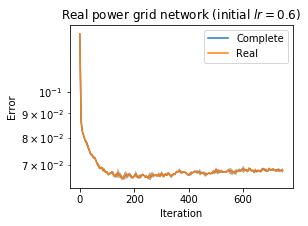

In [73]:
iterations_indices = np.arange(0, losses_real[0].shape[0] * compute_loss_every, 
                               compute_loss_every)
helpers.plot_losses_with_std([losses_complete, losses_real],
            iterations_indices, optimum_loss=optimum_loss,
            labels=["Complete","Real"], title="Real power grid network (initial $lr=0.6$)", 
            figsize=(4,3))#, save_as_pdf=True, pdf_name="real_net_high_lr")

### Compute the losses of complete topology (lr=0.05)

In [61]:
params_complete2 = params.copy()
params_complete2['topology'] = 'complete'
params_complete2['initial_lr'] = 0.05
losses_complete2 = helpers.run_logistic_n_times(A, y, params_complete2, 3)

Decentralized optimization, run number 1 

Epoch      Iteration      Time      Loss      Accuracy      
[1/15]     [50/50]        9s        0.6035    0.7070        
[2/15]     [50/50]        18s       0.5900    0.7103        
[3/15]     [50/50]        28s       0.5848    0.7122        
[4/15]     [50/50]        37s       0.5816    0.7143        
[5/15]     [50/50]        47s       0.5793    0.7153        
[6/15]     [50/50]        57s       0.5775    0.7167        
[7/15]     [50/50]        66s       0.5759    0.7179        
[8/15]     [50/50]        76s       0.5746    0.7186        
[9/15]     [50/50]        86s       0.5735    0.7195        
[10/15]    [50/50]        96s       0.5725    0.7200        
[11/15]    [50/50]        105s      0.5717    0.7205        
[12/15]    [50/50]        116s      0.5709    0.7212        
[13/15]    [50/50]        126s      0.5702    0.7216        
[14/15]    [50/50]        136s      0.5696    0.7222        
[15/15]    [50/50]        146s      0.5690

### Compute the losses of real network topology (lr=0.05)

In [62]:
params_real2 = params.copy()
params_real2['topology'] = nx.adjacency_matrix(G).toarray()
params_real2['initial_lr'] = 0.05
losses_real2 = helpers.run_logistic_n_times(A, y, params_real2, 3)

Decentralized optimization, run number 1 

Epoch      Iteration      Time      Loss      Accuracy      
[1/15]     [50/50]        9s        0.6023    0.7065        
[2/15]     [50/50]        19s       0.5893    0.7100        
[3/15]     [50/50]        29s       0.5861    0.7118        
[4/15]     [50/50]        40s       0.5857    0.7139        
[5/15]     [50/50]        50s       0.5875    0.7147        
[6/15]     [50/50]        60s       0.5895    0.7159        
[7/15]     [50/50]        70s       0.5895    0.7173        
[8/15]     [50/50]        80s       0.5900    0.7183        
[9/15]     [50/50]        90s       0.5898    0.7192        
[10/15]    [50/50]        99s       0.5906    0.7201        
[11/15]    [50/50]        109s      0.5898    0.7206        
[12/15]    [50/50]        119s      0.5904    0.7213        
[13/15]    [50/50]        129s      0.5899    0.7219        
[14/15]    [50/50]        139s      0.5899    0.7225        
[15/15]    [50/50]        148s      0.5886

### Results for lr=0.05

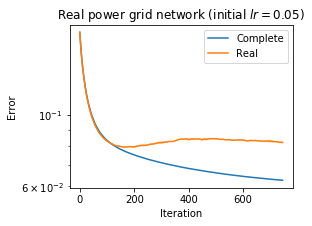

In [72]:
iterations_indices = np.arange(0, losses_real2[0].shape[0] * compute_loss_every, 
                               compute_loss_every)
helpers.plot_losses_with_std([losses_complete2, losses_real2],
            iterations_indices, optimum_loss=optimum_loss,
            labels=["Complete","Real"], title="Real power grid network (initial $lr=0.05$)", 
            figsize=(4,3))#, save_as_pdf=True, pdf_name="real_net_low_lr")